In [3]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter

### Functions

In [4]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var      

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.fmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axn.add_collection(pc)
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.fmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    try:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    except:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

In [5]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [6]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['for_jan18_3','forharoVS_jan18_3','forrosVS_jan18_3','forsjcVS_jan18_3','foradm_jan18_3','fordec_haro3','fordec_sjc3','forharoPR_jan18','forrosPR_jan18','forsjcPR_jan18']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2018,12,28)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t28/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        else:
            name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t21/ariane_positions_quantitative.nc'
            
            if os.path.isfile(name):
                dict_i[date] = xr.open_dataset(name)
            else:
                name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
                
                if os.path.isfile(name):
                    dict_i[date] = xr.open_dataset(name)
                    
                else:
                    name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/for_straight_' + date + '_s1t21/ariane_positions_quantitative.nc'
                
                    if os.path.isfile(name):
                        dict_i[date] = xr.open_dataset(name)
                
        
    dicts[file] = dict_i



In [7]:
dict_secdata = {}

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            dict_secdata[file][section][date] = get_secdata(dicts[file][date],section)


In [8]:
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

sectransp = {}

for file in files:
    sectransp[file] = {}
    
    for section in sectionnum:
        if section not in sectransp[file]:
            sectransp[file][section] = []
            
        for date in dates:
            try:
                sectransp[file][section].append(dict_sectiontransp[file][date][section])
            except:
                print(date)
                pass

17dec18
17dec18
17dec18
17dec18
17dec18
17dec18
17dec18
17dec18
17dec18


In [9]:
dict_age_ref = {}
dict_age_ts = {}

for file in files:
    ref_dict = {}
    ts_dict = {}
    
    for date in dicts[file].keys():
        if date not in ref_dict:
            ref_dict[date] = []
            ts_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            ref_dict[date].append(np.nanmean(allvar['final_age'][allvar['final_age']>=24]))
            ts_dict[date].append(np.nanmean(allvar['final_age'][allvar['final_age']<24]))
    dict_age_ref[file] = ref_dict
    dict_age_ts[file] = ts_dict

age_ref = {}
age_ts = {}

for file in files:
    if file not in age_ref:
        age_ref[file] = {}
        age_ts[file] = {}
        
    for section in sectionnum:
        if section not in age_ref[file]:
            age_ref[file][section] = []
            age_ts[file][section] = []
            
        for date in dicts[file].keys():
            age_ref[file][section].append(dict_age_ref[file][date][section])
            age_ts[file][section].append(dict_age_ts[file][date][section])
            

In [10]:
ref_transp = {}
ts_transp = {}

for file in files:
    ref_transp[file] = []
    ts_transp[file] = []
    
    for date in dates:  
        try:
            ref_transp[file].append(np.sum(dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age'] >= 24]).values/24)
            ts_transp[file].append(np.sum(dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age'] < 24]).values/24)
            
        except:
            print(date)
            pass    
        
        

17dec18


### Salt

In [11]:
ref_salt_final = {}
ts_salt_final = {}
ref_salt_init = {}
ts_salt_init = {}

for file in files:
    ref_salt_final[file] = []
    ts_salt_final[file] = []
    ref_salt_init[file] = []
    ts_salt_init[file] = []
    
    for date in dates:  
        try:     
            ref_salt_final[file].append(np.mean(dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age'] >= 24].values))
            ts_salt_final[file].append(np.mean(dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age'] < 24].values))
            ref_salt_init[file].append(np.mean(dict_secdata[file][0][date]['init_salt'][dict_secdata[file][0][date]['final_age'] >= 24].values))
            ts_salt_init[file].append(np.mean(dict_secdata[file][0][date]['init_salt'][dict_secdata[file][0][date]['final_age'] < 24].values))
        except:
            print(date)
            pass

17dec18


In [12]:
salt_final = {}
salt_init = {}


for file in files:
    salt_final[file] = {}
    salt_init[file] = {}
    
    for section in sectionnum:
        salt_final[file][section] = []
        salt_init[file][section] = []
        
        for date in dates:  
            try:    
                salt_final[file][section].append(np.mean(dict_secdata[file][section][date]['final_salt'].values))
                salt_init[file][section].append(np.mean(dict_secdata[file][section][date]['init_salt'].values))
            except:
                print(date)
                pass

17dec18
17dec18
17dec18
17dec18
17dec18
17dec18
17dec18
17dec18
17dec18


In [13]:
#Efflux north
ref_sji = np.array(ref_transp['forharoVS_jan18_3'])+np.array(ref_transp['forrosVS_jan18_3'])+np.array(ref_transp['forsjcVS_jan18_3'])
ts_sji = np.array(ts_transp['forharoVS_jan18_3'])+np.array(ts_transp['forrosVS_jan18_3'])+np.array(ts_transp['forsjcVS_jan18_3'])

#Reflux south
ref_vs = np.array(ref_transp['for_jan18_3'])
ts_vs = np.array(ts_transp['for_jan18_3'])

vstosji = np.array(sectransp['for_jan18_3'][6])+(np.array(sectransp['for_jan18_3'][5]))+np.array(sectransp['for_jan18_3'][4])
admtosji = np.array(sectransp['foradm_jan18_3'][6])+np.array(sectransp['foradm_jan18_3'][5])+np.array(sectransp['foradm_jan18_3'][4])
sjitovs = np.array(sectransp['forharoVS_jan18_3'][6])+np.array(sectransp['forsjcVS_jan18_3'][5])+np.array(sectransp['forrosVS_jan18_3'][4])

sjitoadm = np.array(sectransp['forharoVS_jan18_3'][2])+np.array(sectransp['forsjcVS_jan18_3'][2])+np.array(sectransp['forrosVS_jan18_3'][2])
vstoadm = sectransp['for_jan18_3'][2]
admtovs = sectransp['foradm_jan18_3'][2]

In [14]:
north_to_sji = admtosji+vstosji

Text(0, 0.5, 'Transort (mSv)')

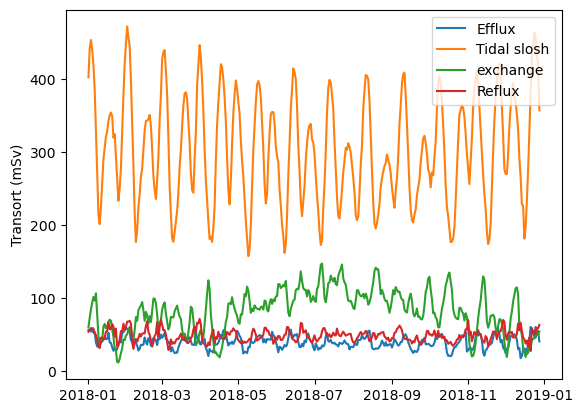

In [15]:
fig,ax = plt.subplots()

ax.plot(datelist_vs,ref_sji/1000,label='Efflux')
ax.plot(datelist_vs,ts_sji/1000,label='Tidal slosh')
ax.plot(datelist_vs,vstosji/1000,label='exchange')
ax.plot(datelist_vs,ref_vs/1000,label='Reflux')
ax.legend(loc=1)
ax.set_ylabel('Transort (mSv)')

Text(0, 0.5, 'Transport (mSv)')

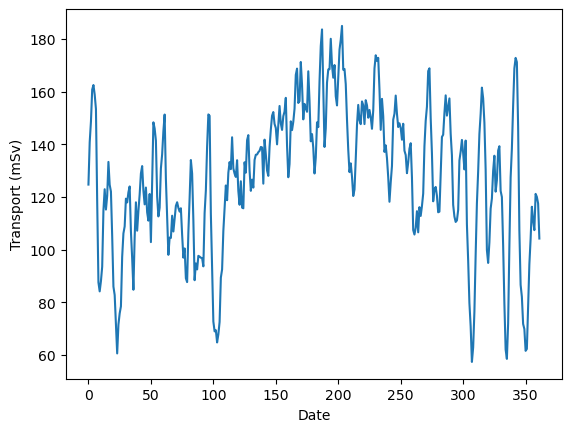

In [16]:
plt.plot(north_to_sji/1000+ref_sji/1000)
plt.xlabel('Date')
plt.ylabel('Transport (mSv)')

In [17]:
np.mean(north_to_sji/1000+ref_sji/1000)

127.80570328820777

Similar to the estimate from MacCready et al. (2021) - 125 mSv

### Salt

In [18]:
salt_flux = {}

for file in files:
    salt_flux[file] = {}
    
    for section in sectionnum:
        salt_flux[file][section] = []
        
        for date in dict_secdata[file][section].keys():
            try:
                salt_flux[file][section].append(np.sum((dict_secdata[file][section][date]['final_salt'].values-dict_secdata[file][section][date]['init_salt'].values)*dict_secdata[file][section][date]['final_transp'].values/24)*1024)
            except:
                print(date)
                pass

In [19]:
salt_ref = {}
salt_ts = {}

for file in files:
    salt_ref[file] = []
    salt_ts[file] = []
        
    for date in dict_secdata[file][0].keys():
        try:
            salt_ref[file].append(np.sum((dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age']>= 24].values - dict_secdata[file][0][date]['init_salt'][dict_secdata[file][0][date]['final_age']>= 24].values)*dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age']>= 24].values/24)*1024)
            salt_ts[file].append(np.sum((dict_secdata[file][0][date]['final_salt'][dict_secdata[file][0][date]['final_age']< 24].values - dict_secdata[file][0][date]['init_salt'][dict_secdata[file][0][date]['final_age']< 24].values)*dict_secdata[file][0][date]['final_transp'][dict_secdata[file][0][date]['final_age']< 24].values/24)*1024)
            
        except:
            print(date)
            pass

In [20]:
salt_admtosji = np.array(salt_flux['foradm_jan18_3'][6]) + np.array(salt_flux['foradm_jan18_3'][5]) + np.array(salt_flux['foradm_jan18_3'][4])
salt_sjitoadm = np.array(salt_flux['forharoVS_jan18_3'][2]) + np.array(salt_flux['forsjcVS_jan18_3'][2]) + np.array(salt_flux['forrosVS_jan18_3'][2])
salt_admtovs = np.array(salt_flux['foradm_jan18_3'][2])
salt_vstoadm = np.array(salt_flux['for_jan18_3'][2])

salt_adm_ref = np.array(salt_ref['foradm_jan18_3'])
salt_adm_ts = np.array(salt_ts['foradm_jan18_3'])

In [21]:
vstodec = np.array(sectransp['for_jan18_3'][3])
dectovs = np.array(sectransp['fordec_haro3'][3])
admtodec = np.array(sectransp['foradm_jan18_3'][3])
dectoadm = np.array(sectransp['fordec_haro3'][2])
sjitodec = np.array(sectransp['forharoVS_jan18_3'][3]) + np.array(sectransp['forsjcVS_jan18_3'][3]) + np.array(sectransp['forrosVS_jan18_3'][3])
dectosji = np.array(sectransp['fordec_sjc3'][6]) + np.array(sectransp['fordec_haro3'][4]) + np.array(sectransp['fordec_haro3'][5])

##Salt

salt_sjitodec = np.array(salt_flux['forharoVS_jan18_3'][3]) + np.array(salt_flux['forsjcVS_jan18_3'][3]) + np.array(salt_flux['forrosVS_jan18_3'][3])
salt_dectosji = np.array(salt_flux['fordec_sjc3'][6]) + np.array(salt_flux['fordec_haro3'][5]) + np.array(salt_flux['fordec_haro3'][4])
salt_admtodec = np.array(salt_flux['foradm_jan18_3'][3])
salt_dectoadm = np.array(salt_flux['fordec_haro3'][2])
salt_vstodec = np.array(salt_flux['for_jan18_3'][3])
salt_dectovs = np.array(salt_flux['fordec_haro3'][3])

In [22]:
salt_vstosji = np.array(salt_flux['for_jan18_3'][6]) + np.array(salt_flux['for_jan18_3'][5]) + np.array(salt_flux['for_jan18_3'][4])
salt_sjitovs = np.array(salt_flux['forharoVS_jan18_3'][6]) + np.array(salt_flux['forsjcVS_jan18_3'][5]) + np.array(salt_flux['forrosVS_jan18_3'][4])

salt_ts_sji = np.array(salt_ts['forharoVS_jan18_3'])+np.array(salt_ts['forrosVS_jan18_3'])+np.array(salt_ts['forsjcVS_jan18_3'])
salt_ts_vs = np.array(salt_ts['for_jan18_3'])
salt_ts_dec = np.array(salt_ts['fordec_haro3'])

#Ref/eff dec
salt_ref_dec = np.array(salt_ref['fordec_haro3'])
salt_ref_vs = np.array(salt_ref['for_jan18_3'])
salt_ref_sji = np.array(salt_ref['forharoVS_jan18_3']) + np.array(salt_ref['forrosVS_jan18_3']) + np.array(salt_ref['forsjcVS_jan18_3'])

In [23]:
bal = (salt_vstosji/1e6+salt_ref_sji/1e6+salt_ts_sji/1e6+salt_ref_vs/1e6+salt_ts_vs/1e6+salt_sjitovs/1e6 
       + salt_admtosji/1e6 + salt_sjitoadm/1e6 + salt_vstoadm/1e6 + salt_admtovs/1e6 + 
       salt_adm_ref/1e6 + salt_adm_ts/1e6)

In [24]:
bal = (salt_vstosji/1e6+salt_ref_sji/1e6+salt_ts_sji/1e6+salt_ref_vs/1e6+salt_ts_vs/1e6+salt_sjitovs/1e6 
       + salt_admtosji/1e6 + salt_sjitoadm/1e6 + salt_vstoadm/1e6 + salt_admtovs/1e6 + 
       salt_adm_ref/1e6 + salt_adm_ts/1e6 + salt_sjitodec/1e6 + salt_dectosji/1e6 + salt_dectoadm/1e6 + salt_admtodec/1e6 
       + salt_vstodec/1e6 + salt_dectovs/1e6 + salt_ref_dec/1e6 + salt_ts_dec/1e6)

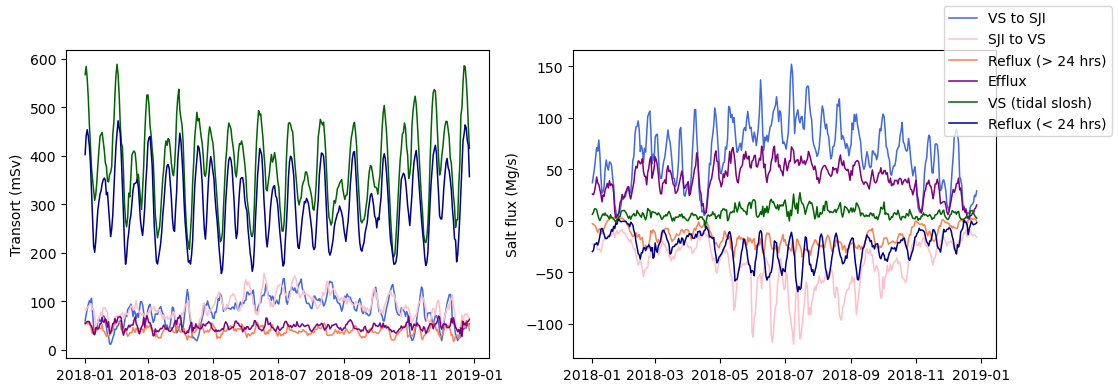

In [25]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(datelist_vs,vstosji/1000,lw=1.1,color='royalblue',label='VS to SJI')
ax[0].plot(datelist_vs,sjitovs/1000,lw=1.1,color='pink',label='SJI to VS')
ax[0].plot(datelist_vs,ref_sji/1000,lw=1.1,color='coral',label='Reflux (> 24 hrs)')
ax[0].plot(datelist_vs,ref_vs/1000,color='purple',lw=1.1,label='Efflux')
ax[0].plot(datelist_vs,ts_vs/1000,lw=1.1,color='darkgreen',label='VS (tidal slosh)')
ax[0].plot(datelist_vs,ts_sji/1000,lw=1.1,label='Reflux (< 24 hrs)',color='darkblue')
ax[0].xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=2)) # Tick frequency
# ax[0].legend(loc=1)
ax[0].set_ylabel('Transort (mSv)')
fig.legend()

ax[1].plot(datelist_vs,-salt_vstosji/1e6,lw=1.1,color='royalblue',label='Exchange')
ax[1].plot(datelist_vs,-salt_ref_sji/1e6 ,lw=1.1,color='coral',label='Reflux (> 24 hrs)')
ax[1].plot(datelist_vs,-salt_ref_vs/1e6,color='purple',lw=1.1,label='Efflux')
ax[1].plot(datelist_vs,-salt_ts_vs/1e6,lw=1.1,color='darkgreen',label='tidal sloshing')
ax[1].plot(datelist_vs,-salt_sjitovs/1e6,lw=1.1,color='pink',label='SJI to VS')
ax[1].plot(datelist_vs,-salt_ts_sji/1e6,lw=1.1,label='Reflux (< 24 hrs)',color='darkblue')
# ax[1].plot(datelist_vs,-bal,lw=1.2,color='black',label='balance')
# ax[1].legend()
ax[1].set_ylabel('Salt flux (Mg/s)');

In [26]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/loop_analysis.png',bbox_inches='tight')

In [27]:
np.sum(-bal)/365

10.535681993705646

### Calculate northward and southward fluxes

#### Haro

In [28]:
vstoharoJan = np.mean(sectransp['for_jan18_3'][6][0:31])
vstoharoJul = np.mean(sectransp['for_jan18_3'][6][181:212])

admtoharoJan = np.mean(sectransp['foradm_jan18_3'][6][0:31])
admtoharoJul = np.mean(sectransp['foradm_jan18_3'][6][181:212])

EffHaroJan = np.mean(ref_transp['forharoVS_jan18_3'][0:31])
EffHaroJul = np.mean(ref_transp['forharoVS_jan18_3'][181:212])

In [29]:
NorthHaroJan = vstoharoJan + admtoharoJan + EffHaroJan
NorthHaroJul = vstoharoJul + admtoharoJul + EffHaroJul
print(NorthHaroJan)
print(NorthHaroJul)

88555.56375258966
131288.34985357107


In [30]:
harotovsJan = np.mean(sectransp['forharoVS_jan18_3'][6][0:31])
harotovsJul = np.mean(sectransp['forharoVS_jan18_3'][6][181:212])

harotoadmJan = np.mean(sectransp['forharoVS_jan18_3'][2][0:31])
harotoadmJul = np.mean(sectransp['forharoVS_jan18_3'][2][181:212])

RefHaroJan = np.mean(ref_transp['forharoPR_jan18'][0:31])
RefHaroJul = np.mean(ref_transp['forharoPR_jan18'][181:212])

In [31]:
SouthHaroJan = harotovsJan + harotoadmJan + RefHaroJan
SouthHaroJul = harotovsJul + harotoadmJul + RefHaroJul
print(SouthHaroJan)
print(SouthHaroJul)


110713.56158314846
121262.25910959087


#### Rosario

In [32]:
vstorosJan = np.mean(sectransp['for_jan18_3'][4][0:31])
vstorosJul = np.mean(sectransp['for_jan18_3'][4][181:212])

admtorosJan = np.mean(sectransp['foradm_jan18_3'][4][0:31])
admtorosJul = np.mean(sectransp['foradm_jan18_3'][4][181:212])

EffrosJan = np.mean(ref_transp['forrosVS_jan18_3'][0:31])
EffrosJul = np.mean(ref_transp['forrosVS_jan18_3'][181:212])

In [33]:
NorthRosJan = vstorosJan + admtorosJan + EffrosJan
NorthRosJul = vstorosJul + admtorosJul + EffrosJul
print(NorthRosJan)
print(NorthRosJul)

15275.454496096329
21262.293582380677


In [34]:
rostovsJan = np.mean(sectransp['forrosVS_jan18_3'][4][0:31])
rostovsJul = np.mean(sectransp['forrosVS_jan18_3'][4][181:212])

rostoadmJan = np.mean(sectransp['forrosVS_jan18_3'][2][0:31])
rostoadmJul = np.mean(sectransp['forrosVS_jan18_3'][2][181:212])

RefrosJan = np.mean(ref_transp['forrosPR_jan18'][0:31])
RefrosJul = np.mean(ref_transp['forrosPR_jan18'][181:212])

In [35]:
SouthRosJan = rostovsJan + rostoadmJan + RefrosJan
SouthRosJul = rostovsJul + rostoadmJul + RefrosJul
print(SouthRosJan)
print(SouthRosJul)

19436.38904824524
52629.57517203894


#### SJC

In [36]:
vstosjcJan = np.mean(sectransp['for_jan18_3'][5][0:31])
vstosjcJul = np.mean(sectransp['for_jan18_3'][5][181:212])

admtosjcJan = np.mean(sectransp['foradm_jan18_3'][5][0:31])
admtosjcJul = np.mean(sectransp['foradm_jan18_3'][5][181:212])

EffsjcJan = np.mean(ref_transp['forsjcVS_jan18_3'][0:31])
EffsjcJul = np.mean(ref_transp['forsjcVS_jan18_3'][181:212])

In [37]:
NorthsjcJan = vstosjcJan + admtosjcJan + EffsjcJan
NorthsjcJul = vstosjcJul + admtosjcJul + EffsjcJul
print(NorthsjcJan)
print(NorthsjcJul)

7055.014589205129
5932.054757256776


In [38]:
sjctovsJan = np.mean(sectransp['forsjcVS_jan18_3'][5][0:31])
sjctovsJul = np.mean(sectransp['forsjcVS_jan18_3'][5][181:212])

sjctoadmJan = np.mean(sectransp['forsjcVS_jan18_3'][2][0:31])
sjctoadmJul = np.mean(sectransp['forsjcVS_jan18_3'][2][181:212])

RefsjcJan = np.mean(ref_transp['forsjcPR_jan18'][0:31])
RefsjcJul = np.mean(ref_transp['forsjcPR_jan18'][181:212])

In [39]:
SouthsjcJan = sjctovsJan + sjctoadmJan + RefsjcJan
SouthsjcJul = sjctovsJul + sjctoadmJul + RefsjcJul
print(SouthsjcJan)
print(SouthsjcJul)

13620.704880783916
20848.497950935256
